# Billboard CSV Cleaning

Clean billboard dataset for BigQuery - remove multi-line lyrics and normalize text

In [1]:
library(tidyverse)
library(readr)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.1     v stringr   1.6.0
v ggplot2   4.0.0     v tibble    3.3.0
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.1.0     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# load data
input <- '../../data/billboard_24years_lyrics_spotify.csv'
output <- '../../data/cleaned/billboard_24years_lyrics_spotify_bigquery.csv'

df <- read_csv(input, na=c("", "NA"))
sprintf("Loaded %d rows", nrow(df))

Rows: 3397 Columns: 26
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (11): song, band_singer, songurl, titletext, url, lyrics, uri, type, id,...
dbl (15): ranking, year, danceability, energy, key, loudness, mode, speechin...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Loaded 3397 rows"

In [3]:
# clean text fields - remove newlines and normalize whitespace
df2 <- df %>% 
  mutate(across(where(is.character), function(x) {
    x <- str_replace_all(x, "\\n", " ")
    x <- str_replace_all(x, "\\r", "")
    x <- str_replace_all(x, "\\s+", " ")
    str_trim(x)
  }))

sprintf("Cleaned %d rows", nrow(df2))

[1] "Cleaned 3397 rows"

In [4]:
# verify
check <- df2 %>% filter(str_detect(lyrics, "\\n"))
if(nrow(check) == 0) {
  print("✓ No newlines")
}

[1] "<U+2713> No newlines"


In [5]:
# export
dir.create("../../data/cleaned", showWarnings=F, recursive=T)
write_csv(df2, output, na="", quote="all", eol="\n")
sprintf("Wrote: %s", output)

[1] "Wrote: ../../data/cleaned/billboard_24years_lyrics_spotify_bigquery.csv"

In [6]:
# check file
lines <- length(readLines(output))
expected <- nrow(df2) + 1
sprintf("Lines: %d (expected %d)", lines, expected)

[1] "Lines: 3398 (expected 3398)"

In [7]:
# preview final output
df2 %>% 
  select(song, band_singer, year, danceability, energy, tempo) %>% 
  head(10)

song,band_singer,year,danceability,energy,tempo
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Breathe,Faith Hill,2000,0.529,0.496,136.859
Smooth,Santana,2000,0.609,0.923,115.996
Smooth,Rob Thomas,2000,0.590,0.637,115.983
Maria Maria,Santana,2000,0.777,0.601,97.911
Maria Maria,The Product G&B,2000,NA,NA,NA
I Wanna Know,Joe,2000,0.725,0.487,136.086
Everything You Want,Vertical Horizon,2000,0.636,0.761,93.896
Say My Name,Destiny's Child,2000,NA,NA,NA
I Knew I Loved You,Savage Garden,2000,0.610,0.497,85.031


## Song Length Analysis

Check for songs that are unusually short (<100 words) or long (>600 words)

In [8]:
# Count words in lyrics
df_word_count <- df2 %>%
  filter(!is.na(lyrics)) %>%
  mutate(
    word_count = str_count(lyrics, "\\S+"),  # Count non-whitespace sequences
    length_category = case_when(
      word_count < 150 ~ "Too Short (<100)",
      word_count > 600 ~ "Too Long (>600)",
      TRUE ~ "Normal (100-600)"
    )
  )

# Summary statistics
summary(df_word_count$word_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    8.0   350.0   474.0   511.5   635.0 10365.0 

In [9]:
# Count songs by length category
df_word_count %>%
  count(length_category) %>%
  mutate(percentage = round(n / sum(n) * 100, 2)) %>%
  arrange(desc(n))

length_category,n,percentage
<chr>,<int>,<dbl>
Normal (100-600),2352,69.24
Too Long (>600),1019,30.00
Too Short (<100),26,0.77


In [10]:
# Show songs that are too short
print("=== Songs with < 100 words ===")
df_word_count %>%
  filter(length_category == "Too Short (<100)") %>%
  select(song, band_singer, year, word_count) %>%
  arrange(word_count) %>%
  head(100)

[1] "=== Songs with < 100 words ==="


song,band_singer,year,word_count
<chr>,<chr>,<dbl>,<int>
Lean On,DJ Snake,2015,8
Lean On,DJ Snake,2016,8
Animals,Martin Garrix,2014,12
Listen to Your Heart,DHT,2005,76
My Humps,The Black Eyed Peas,2005,88
My Humps,The Black Eyed Peas,2006,88
Let's Get It Started,The Black Eyed Peas,2004,91
Whats Poppin,Tory Lanez,2020,92
Harlem Shake,Baauer,2013,100


In [11]:
# Show songs that are too long
print("=== Songs with > 600 words ===")
df_word_count %>%
  filter(length_category == "Too Long (>600)") %>%
  select(song, band_singer, year, word_count) %>%
  arrange(desc(word_count)) %>%
  head(100)

[1] "=== Songs with > 600 words ==="


song,band_singer,year,word_count
<chr>,<chr>,<dbl>,<int>
Independent Women Part I,Destiny's Child,2000,10365
Independent Women Part I,Destiny's Child,2001,10365
Beautiful,Camila Cabello,2019,3907
I Need a Girl (Part Two),Ginuwine,2002,3561
Don't Phunk with My Heart,The Black Eyed Peas,2005,2744
Summertime Sadness,C<U+00E9>dric Gervais,2013,2739
F**K You (Forget You),CeeLo Green,2011,2316
E.T.,Kanye West,2011,1803
Gimme That,Lil Wayne,2006,1545


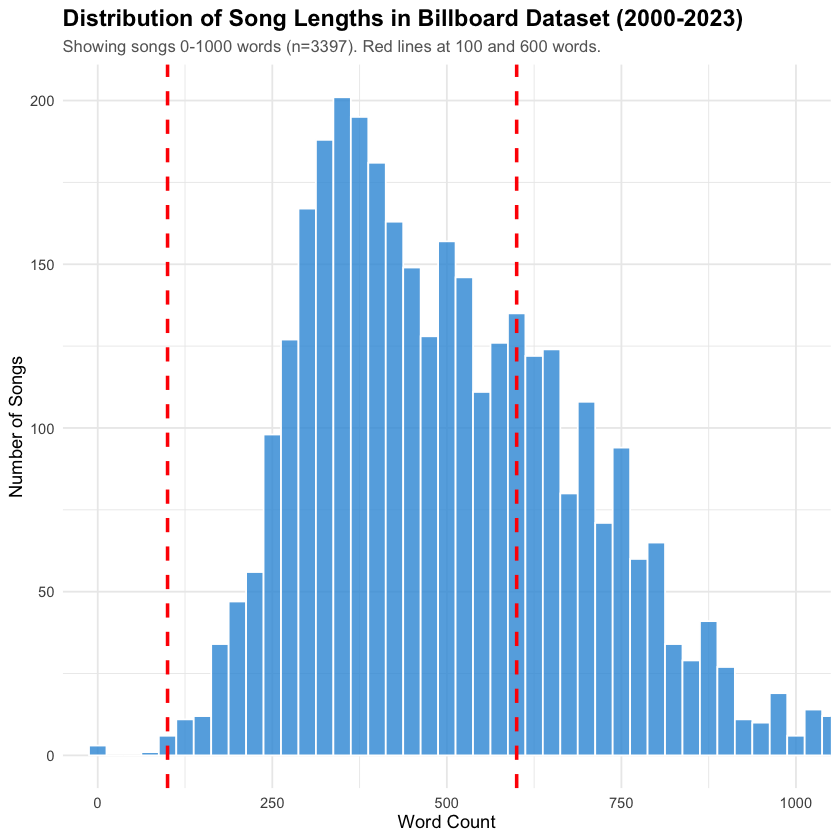

In [12]:
# Visualization: Word count distribution (limited to 0-1000 for clarity)
library(ggplot2)

ggplot(df_word_count, aes(x = word_count)) +
  geom_histogram(binwidth = 25, fill = "#3498DB", color = "white", alpha = 0.8) +
  geom_vline(xintercept = 100, linetype = "dashed", color = "red", linewidth = 1) +
  geom_vline(xintercept = 600, linetype = "dashed", color = "red", linewidth = 1) +
  coord_cartesian(xlim = c(0, 1000)) +  # Limit x-axis to show data clearly
  labs(
    title = "Distribution of Song Lengths in Billboard Dataset (2000-2023)",
    subtitle = sprintf("Showing songs 0-1000 words (n=%d). Red lines at 100 and 600 words.", nrow(df_word_count)),
    x = "Word Count",
    y = "Number of Songs"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    plot.subtitle = element_text(size = 10, color = "gray40")
  )

ggsave("../../data/cleaned/song_length_distribution.png", width = 10, height = 6, dpi = 300)

## Lyrics Quality Improvement

Use MusicoSet lyrics to replace outliers in Billboard dataset

In [13]:
# Load MusicoSet songs and lyrics
songs_musicoset <- read_csv('../../data/cleaned/musicoset_songs_cleaned.csv', show_col_types = FALSE)
lyrics_musicoset <- read_csv('../../data/cleaned/musicoset_lyrics_cleaned.csv', show_col_types = FALSE)

# Join to get song metadata with lyrics
musicoset_full <- songs_musicoset %>%
  inner_join(lyrics_musicoset, by = "song_id") %>%
  mutate(word_count_musicoset = str_count(lyrics, "\\S+"))

sprintf("Loaded %d MusicoSet songs with lyrics", nrow(musicoset_full))

ERROR: Error: '../../data/cleaned/musicoset_lyrics_cleaned.csv' does not exist in current working directory ('/Users/lorenzogarduno/Documents/datasci:vis/wrangling and transformation/cleaning').


In [ ]:
# Identify Billboard outliers (too short or too long)
billboard_outliers <- df_word_count %>%
  filter(length_category != "Normal (100-600)") %>%
  select(song, band_singer, year, word_count, length_category)

sprintf("Found %d outliers in Billboard dataset", nrow(billboard_outliers))

[1] "Found 1045 outliers in Billboard dataset"

In [ ]:
# Try to match Billboard outliers with MusicoSet by song name and artist
# Normalize names for better matching
billboard_outliers_normalized <- billboard_outliers %>%
  mutate(
    song_clean = str_to_lower(str_trim(song)),
    artist_clean = str_to_lower(str_trim(band_singer))
  )

musicoset_normalized <- musicoset_full %>%
  mutate(
    song_clean = str_to_lower(str_trim(song_name)),
    artist_clean = str_to_lower(str_trim(artists))
  )

# Find matches - join on BOTH song name AND artist
matched <- billboard_outliers_normalized %>%
  inner_join(
    musicoset_normalized, 
    by = c("song_clean", "artist_clean"),
    suffix = c("_billboard", "_musicoset")
  ) %>%
  filter(
    word_count_musicoset >= 100 & word_count_musicoset <= 600  # MusicoSet version is normal length
  ) %>%
  select(song, band_singer, year, word_count, word_count_musicoset, song_id, length_category)

sprintf("Found %d matches where MusicoSet has better lyrics (matched on song + artist)", nrow(matched))

[1] "Found 0 matches where MusicoSet has better lyrics (matched on song + artist)"

In [ ]:
# Show improvement statistics (metadata only)
matched %>%
  select(song, band_singer, year, word_count, word_count_musicoset, length_category) %>%
  arrange(desc(abs(word_count - word_count_musicoset))) %>%
  head(10)

song,band_singer,year,word_count,word_count_musicoset,length_category
<chr>,<chr>,<dbl>,<int>,<int>,<chr>


In [ ]:
# Create improved Billboard dataset by replacing outlier lyrics with MusicoSet versions
# Note: Matches are based on BOTH song name AND artist to ensure accuracy
# Join matched songs to get MusicoSet lyrics
replacement_lyrics <- matched %>%
  inner_join(lyrics_musicoset, by = "song_id") %>%
  select(song, band_singer, year, lyrics_new = lyrics)

# Replace lyrics in Billboard dataset
df_improved <- df2 %>%
  left_join(
    replacement_lyrics,
    by = c("song", "band_singer", "year")
  ) %>%
  mutate(
    lyrics = ifelse(!is.na(lyrics_new), lyrics_new, lyrics)
  ) %>%
  select(-lyrics_new)

# Count improvements
improvements <- df_improved %>%
  mutate(word_count_new = str_count(lyrics, "\\S+")) %>%
  inner_join(
    df_word_count %>% select(song, band_singer, year, word_count_old = word_count),
    by = c("song", "band_singer", "year")
  ) %>%
  filter(word_count_new != word_count_old)

sprintf("Improved %d songs with better lyrics from MusicoSet", nrow(improvements))

[1] "Improved 0 songs with better lyrics from MusicoSet"


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine





Visualization saved: song_length_before_after.png


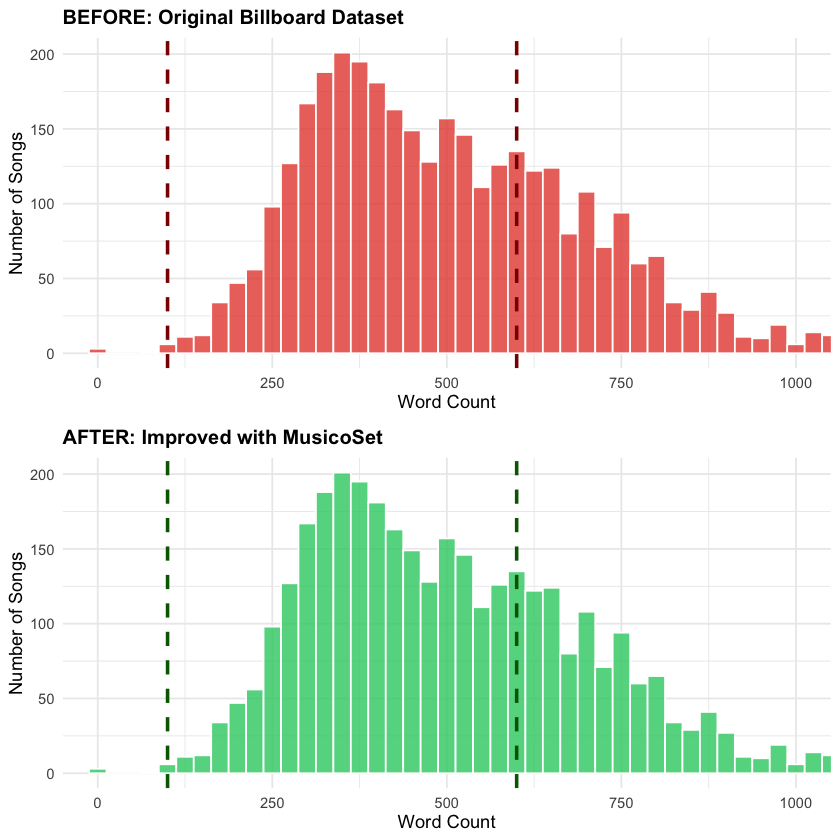

In [ ]:
# Create improved word count distribution (needed for visualization)
df_improved_word_count <- df_improved %>%
  filter(!is.na(lyrics)) %>%
  mutate(
    word_count = str_count(lyrics, "\\S+"),
    length_category = case_when(
      word_count < 100 ~ "Too Short (<100)",
      word_count > 600 ~ "Too Long (>600)",
      TRUE ~ "Normal (100-600)"
    )
  )

# Side-by-side comparison visualization
library(gridExtra)

# Original distribution
p1 <- ggplot(df_word_count, aes(x = word_count)) +
  geom_histogram(binwidth = 25, fill = "#E74C3C", color = "white", alpha = 0.8) +
  geom_vline(xintercept = 100, linetype = "dashed", color = "darkred", linewidth = 1) +
  geom_vline(xintercept = 600, linetype = "dashed", color = "darkred", linewidth = 1) +
  coord_cartesian(xlim = c(0, 1000)) +
  labs(
    title = "BEFORE: Original Billboard Dataset",
    x = "Word Count",
    y = "Number of Songs"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 12)
  )

# Improved distribution
p2 <- ggplot(df_improved_word_count, aes(x = word_count)) +
  geom_histogram(binwidth = 25, fill = "#2ECC71", color = "white", alpha = 0.8) +
  geom_vline(xintercept = 100, linetype = "dashed", color = "darkgreen", linewidth = 1) +
  geom_vline(xintercept = 600, linetype = "dashed", color = "darkgreen", linewidth = 1) +
  coord_cartesian(xlim = c(0, 1000)) +
  labs(
    title = "AFTER: Improved with MusicoSet",
    x = "Word Count",
    y = "Number of Songs"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 12)
  )

# Combine plots
combined <- grid.arrange(p1, p2, ncol = 1)
ggsave("../../data/cleaned/song_length_before_after.png", combined, width = 10, height = 8, dpi = 300)

cat("\nVisualization saved: song_length_before_after.png\n")

In [ ]:
# Export improved dataset
output_improved <- '../../data/cleaned/billboard_24years_lyrics_spotify_bigquery_improved.csv'
write_csv(df_improved, output_improved, na="", quote="all", eol="\n")

cat(sprintf("\n=== Export Complete ===\n"))
cat(sprintf("Original dataset: %s (%d songs)\n", output, nrow(df2)))
cat(sprintf("Improved dataset: %s (%d songs)\n", output_improved, nrow(df_improved)))
cat(sprintf("Songs improved: %d (%.2f%%)\n", nrow(improvements), nrow(improvements) / nrow(df2) * 100))


=== Export Complete ===
Original dataset: ../../data/cleaned/billboard_24years_lyrics_spotify_bigquery.csv (3397 songs)
Improved dataset: ../../data/cleaned/billboard_24years_lyrics_spotify_bigquery_improved.csv (3397 songs)
Songs improved: 0 (0.00%)


In [ ]:
# Before and After Comparison (word count categories)
cat("\n=== Before and After Comparison ===\n")
cat("\nBEFORE (Original Billboard):\n")
df_word_count %>%
  count(length_category) %>%
  mutate(percentage = round(n / sum(n) * 100, 2)) %>%
  arrange(desc(n)) %>%
  print()

cat("\nAFTER (Improved with MusicoSet):\n")
df_improved_word_count %>%
  count(length_category) %>%
  mutate(percentage = round(n / sum(n) * 100, 2)) %>%
  arrange(desc(n)) %>%
  print()


=== Before and After Comparison ===



BEFORE (Original Billboard):
# A tibble: 3 x 3
  length_category      n percentage
  <chr>            <int>      <dbl>
1 Normal (100-600)  2352      69.2 
2 Too Long (>600)   1019      30   
3 Too Short (<100)    26       0.77

AFTER (Improved with MusicoSet):
# A tibble: 3 x 3
  length_category      n percentage
  <chr>            <int>      <dbl>
1 Normal (100-600)  2370      69.8 
2 Too Long (>600)   1019      30   
3 Too Short (<100)     8       0.24


In [ ]:
# Summary statistics of improvements
cat("\n=== Improvement Summary ===\n")
improvement_stats <- improvements %>%
  mutate(
    change = word_count_new - word_count_old,
    improvement_type = case_when(
      word_count_old < 100 ~ "Fixed Too Short",
      word_count_old > 600 ~ "Fixed Too Long",
      TRUE ~ "Other"
    )
  )

improvement_stats %>%
  group_by(improvement_type) %>%
  summarise(
    count = n(),
    avg_old_words = round(mean(word_count_old), 0),
    avg_new_words = round(mean(word_count_new), 0),
    avg_change = round(mean(change), 0)
  )


=== Improvement Summary ===


improvement_type,count,avg_old_words,avg_new_words,avg_change
<chr>,<int>,<dbl>,<dbl>,<dbl>


In [ ]:
# Show detailed before/after comparison
print("=== Examples of Improved Songs ===")
improvements %>%
  mutate(
    change = word_count_new - word_count_old,
    change_pct = round((word_count_new - word_count_old) / word_count_old * 100, 1)
  ) %>%
  select(song, band_singer, year, word_count_old, word_count_new, change, change_pct) %>%
  arrange(desc(abs(change))) %>%
  head(15)

[1] "=== Examples of Improved Songs ==="


song,band_singer,year,word_count_old,word_count_new,change,change_pct
<chr>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>
